# Loading observational data into Bagpipes

This example will show you how to input observational data. For further information see the [loading observational data](http://bagpipes.readthedocs.io/en/latest/loading_galaxies.html) page of the documentation.

## The load_data function

In order to load up data you need to write a function which accepts an ID (as a string) and returns your data in the format Bagpipes expects. 

For photometry this format is a nx2 array containing fluxes and flux errors in microJanskys. For spectroscopy this format is a nx3 array containing wavelengths in angstroms, fluxes and flux errors in ergs/s/cm^2/A.

Below is an example load data function for loading photometry from the [Guo et al. (2013) catalogue](https://archive.stsci.edu/prepds/candels). This catalogue is not included in the repository.

In [1]:
import numpy as np 
import bagpipes as pipes

from astropy.io import fits

def load_goodss(ID):
    """ Load UltraVISTA photometry from catalogue. """

    # load up the relevant columns from the catalogue.
    cat = np.loadtxt("hlsp_candels_hst_wfc3_goodss-tot-multiband_f160w_v1-1photom_cat.txt",
                     usecols=(10, 13, 16, 19, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55,
                              11, 14, 17, 20, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56))
    
    # Find the correct row for the object we want.
    row = int(ID) - 1

    # Extract the object we want from the catalogue.
    fluxes = cat[row, :15]
    fluxerrs = cat[row, 15:]

    # Turn these into a 2D array.
    photometry = np.c_[fluxes, fluxerrs]

    # blow up the errors associated with any missing fluxes.
    for i in range(len(photometry)):
        if (photometry[i, 0] == 0.) or (photometry[i, 1] <= 0):
            photometry[i,:] = [0., 9.9*10**99.]
            
    # Enforce a maximum SNR of 20, or 10 in the IRAC channels.
    for i in range(len(photometry)):
        if i < 10:
            max_snr = 20.
            
        else:
            max_snr = 10.
        
        if photometry[i, 0]/photometry[i, 1] > max_snr:
            photometry[i, 1] = photometry[i, 0]/max_snr

    return photometry

Let's pick object 17433 as a test case to check this works.

In [2]:
print(load_goodss("17433"))

[[6.987040e-02 7.049980e-03]
 [1.923840e-01 4.059220e-02]
 [8.308090e-01 4.154045e-02]
 [2.950840e+00 1.475420e-01]
 [7.377370e+00 3.688685e-01]
 [9.502210e+00 4.751105e-01]
 [0.000000e+00 9.900000e+99]
 [1.516060e+01 7.580300e-01]
 [2.142950e+01 1.071475e+00]
 [3.460530e+01 1.730265e+00]
 [3.460900e+01 3.460900e+00]
 [5.131500e+01 5.131500e+00]
 [3.950320e+01 3.950320e+00]
 [2.687740e+01 2.687740e+00]
 [1.799710e+01 1.799710e+00]]


All that's needed now is to pass the ID and load_goodss function to the bagpipes galaxy class, along with the filt_list from Example 1.

As we're not inputting any spectroscopic data we'll also need to set the keyword argument spectrum_exists to False:

/Users/adam/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


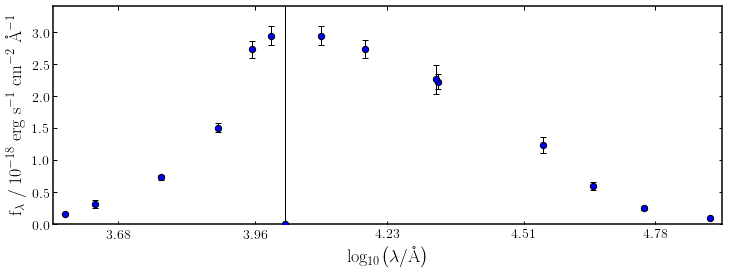

In [3]:
goodss_filt_list = np.loadtxt("filters/goodss_filt_list.txt", dtype="str")

galaxy = pipes.galaxy("17433", load_goodss, spectrum_exists=False, filt_list=goodss_filt_list)
fig = galaxy.plot()

## Adding spectroscopic data

The data load function can return photometry, spectroscopy or both. Let's try an example with spectroscopy. Fortuitously, the object above has also been observed by the VANDELS survey. The fits file in this directory comes from DR2. We can load it with the following function:

In [4]:
def bin(spectrum, binn):
    """ Bins up two or three column spectral data by a specified factor. """

    binn = int(binn)
    nbins = len(spectrum) // binn
    binspec = np.zeros((nbins, spectrum.shape[1]))

    for i in range(binspec.shape[0]):
        spec_slice = spectrum[i*binn:(i+1)*binn, :]
        binspec[i, 0] = np.mean(spec_slice[:, 0])
        binspec[i, 1] = np.mean(spec_slice[:, 1])

        if spectrum.shape[1] == 3:
            binspec[i,2] = (1./float(binn)
                            *np.sqrt(np.sum(spec_slice[:, 2]**2)))

    return binspec


def load_vandels_spec(ID):
    """ Loads VANDELS spectroscopic data from file. """

    hdulist = fits.open("VANDELS_CDFS_" + ID + ".fits")

    spectrum = np.c_[hdulist[1].data["WAVE"][0],
                     hdulist[1].data["FLUX"][0],
                     hdulist[1].data["ERR"][0]]

    mask = (spectrum[:,0] < 9250.) & (spectrum[:,0] > 5250.)

    return bin(spectrum[mask], 2)

This time there's no need to pass the filt_list argument, and it's the photometry_exists keyword argument we need to set to False:

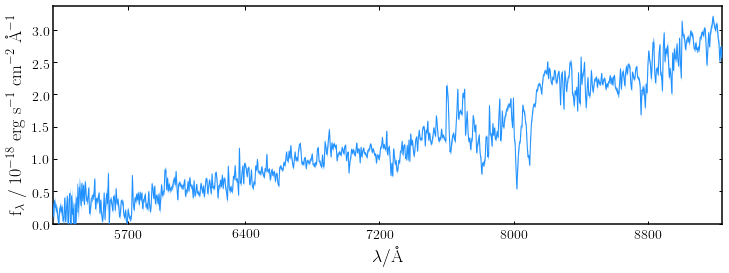

In [5]:
galaxy = pipes.galaxy("017433", load_vandels_spec, photometry_exists=False)

fig = galaxy.plot()

## Loading photometry and spectroscopy

Now let's put it all together. We can define a function which calls both load_uvista and load_legac_spec and returns the spectrum and photometry. When we're loading both kinds of data, bagpipes expects the spectrum first and then the photometry, like so:

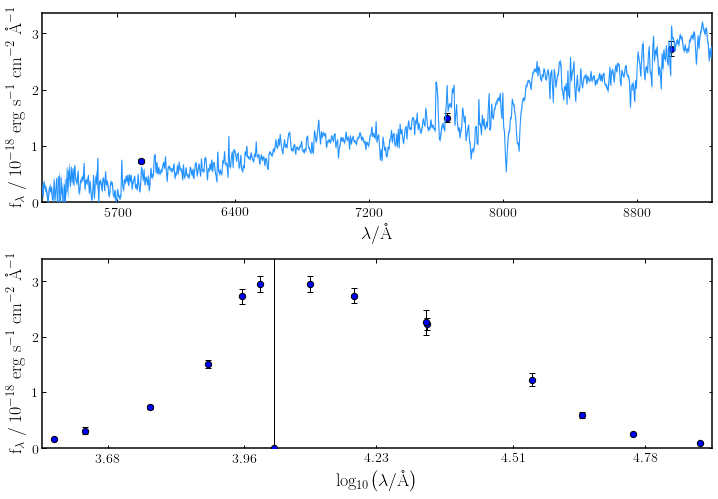

In [6]:
def load_both(ID):
    spectrum = load_vandels_spec(ID)
    phot = load_goodss(ID)

    return spectrum, phot

galaxy = pipes.galaxy("017433", load_both, filt_list=goodss_filt_list)

fig = galaxy.plot()

That's about all there is to know, you can see that photometric points which fall within the wavelength range of the spectrum are plotted on the upper panel so you can see how well the calibration of the spectrum and photometry agrees.